In [34]:
import requests

def getsteamjsondata(steamid):
    req = requests.get("https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key=E4FC832CB48AB086CD31B865EDE2539D&steamid={}&include_appinfo=true&include_played_free_games=true&appids_filter=false".format(steamid))
    return req.text    

with open("gameData.txt", "w") as game_file:
    with open("123.txt", "r") as text_file:
        lincnt = 1
        line = text_file.readline()
        while line:
            if lincnt % 100 == 0:
                print("Done for i = " + lincnt)
            stmid = line[0:len(line)-1]
            jsonresponse = getsteamjsondata(stmid)
            game_file.write(stmid + "\t" + jsonresponse + '\n')
            line = text_file.readline()
            lincnt = lincnt + 1

In [59]:
import pandas as pd

df = pd.read_csv('final_data.csv')
df = df[:404933]
df

,Unnamed: 0,steamid,appid,playtime_forever
0,0,76561197960270862,30,4
1,1,76561197960270862,220,1631
2,2,76561197960270862,300,205
3,3,76561197960270862,380,229
4,4,76561197960270862,400,365
5,5,76561197960270862,420,338
6,6,76561197960270862,500,548
7,7,76561197960270862,550,21114
8,8,76561197960270862,620,2093
9,9,76561197960270862,1250,338


### Making a DataFrame :

In [26]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 1000000000000000000000, 'display.max_rows', 100000000000000000000000)
df.head()

,Unnamed: 0,steamid,appid,playtime_forever
0,0.0,7.656120e+16,20.0,0.0
1,1.0,7.656120e+16,30.0,0.0
2,2.0,7.656120e+16,40.0,0.0
3,3.0,7.656120e+16,50.0,0.0
4,4.0,7.656120e+16,60.0,0.0


### Removing Zero Playtime Data :
We remove the zero-playtime data for building models since we treat zero-playtime and not playing as equal. This renders smaller sized data without losing any information.

In [60]:
df = df[df["playtime_forever"] != 0]
df.head()

,Unnamed: 0,steamid,appid,playtime_forever
0,0,76561197960270862,30,4
1,1,76561197960270862,220,1631
2,2,76561197960270862,300,205
3,3,76561197960270862,380,229
4,4,76561197960270862,400,365


### Density of raw data :

In [61]:
density = lambda df : len(df) / (df["steamid"].nunique() * df["appid"].nunique())
print("Unique SteamIds :", df["steamid"].nunique())
print("Unique AppIds :", df["appid"].nunique())
print("Density : {0:.2f} %".format(density(df) * 100))

Unique SteamIds : 846
Unique AppIds : 12381
Density : 3.87 %


### Sampling :
Since games that have few players are not useful for recommendation, we discard such games. Similarly, players that have few games in their library are not useful for recommendation and we discard such players as well. The two criterias based on which we discard are 
1. Discard a `appid` if it has less than `c1` unique players
2. Discard a `steamid` if it has less than `c2` unique games played

We determine cutoffs `c1` and `c2` by the distribution of `steamid` counts and `appid` counts respectively. 

#### Grouping by `appid` to get player count for each `appid` :

#### To determine `c1`, we plot the number of `appids` against unique `steamids`. 
For example, (1, 100) corresponds to there being 100 games that have only 1 player.

In [62]:
groupby_appid = df.groupby(by = "appid")["steamid"].count()
elbow_appid = groupby_appid.groupby(groupby_appid).count()
x, y = elbow_appid.index, elbow_appid.values
groupby_appid.head()

appid
10    542
20    270
30    275
40    183
50    238
Name: steamid, dtype: int64

In [63]:
len(groupby_appid[groupby_appid == 1])
elbow_appid.head()

steamid
1    1205
2    1186
3     811
4     699
5     551
Name: steamid, dtype: int64

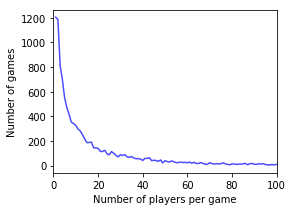

In [64]:
fig, ax = plt.subplots(figsize = (4, 3))
ax.plot(x, y, color = "blue", alpha = 0.7)
ax.set_xlabel("Number of players per game")
ax.set_ylabel("Number of games")
ax.set_xlim([0,100])
fig.savefig("c1.svg")
plt.show()

We choose `c1` = 10, based on intuition.

In [65]:
filter_appid = groupby_appid[groupby_appid > 10]
filter_appid_df = pd.merge(filter_appid.reset_index(), df, on = "appid").drop("steamid_x", axis = 1).rename(index = int, columns = {"steamid_y" : "steamid"})
filter_appid_df.head()

,appid,Unnamed: 0,steamid,playtime_forever
0,10,224,76561197960275345,1
1,10,307,76561197960290105,2
2,10,1061,76561197960321194,3
3,10,1508,76561197960324042,145589
4,10,1576,76561197960332616,261


In [66]:
print("Unique SteamIds :", filter_appid_df["steamid"].nunique())
print("Unique AppIds :", filter_appid_df["appid"].nunique())
print("Density : {0:.2f} %".format(density(filter_appid_df) * 100))

Unique SteamIds : 846
Unique AppIds : 6025
Density : 7.43 %


By removing sparse games, the density of the new data has improved. The unique `appids` have  decreased while the unique `steamids` have not decreased. We now perform a similar procedure that discards the sparse players.

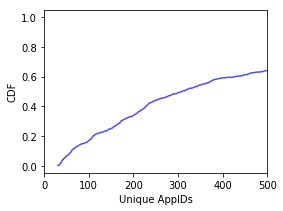

In [67]:
groupby_steamid = filter_appid_df.groupby(by = "steamid").count()["appid"]
groupby_steamid_nparr = groupby_steamid.values
fig, ax = plt.subplots(figsize = (4, 3))#ncols = 2, figsize = (14, 4))
counts, bin_edges = np.histogram(groupby_steamid_nparr, bins = 2000, density = True)
ecdf = np.cumsum(counts)
#ax.hist(groupby_steamid_nparr, density = True, bins = 2000, color = "blue", alpha = 0.7)
#ax.set_xlabel("Unique AppIDs")
#ax.set_xlim([0, 500])
#ax.set_ylabel("PDF")
ax.plot(bin_edges[1:], ecdf/ecdf[-1], color = "blue", alpha = 0.7)
ax.set_xlim([0, 500])
ax.set_xlabel("Unique AppIDs")
ax.set_ylabel("CDF")
#ax.set_title("CDF")
fig.savefig("c2_cdf.svg")

plt.show()

We determine `c2` to be 35, the reason being that the distribution of `appid` counts start to increase rapidly after 65 (users with number of unique games less than 65 are rare). We want to discard such users because they are quite sparse compared to the rest of the data and result in negligible data loss but noticably increase the density.

In [68]:
filter_steamid = groupby_steamid[groupby_steamid > 35]
filter_steamid_df = pd.merge(filter_steamid.reset_index(), filter_appid_df, on = "steamid").drop("appid_x", axis = 1).rename(index = int, columns = {"appid_y" : "appid"})
print("Unique SteamIds :", filter_steamid_df["steamid"].nunique())
print("Unique AppIds :", filter_steamid_df["appid"].nunique())
print("Density : {0:.2f} %".format(density(filter_steamid_df) * 100))

Unique SteamIds : 840
Unique AppIds : 6025
Density : 7.47 %


## CDF play time analysis

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [69]:
data = df
data.head()

,Unnamed: 0,steamid,appid,playtime_forever
0,0,76561197960270862,30,4
1,1,76561197960270862,220,1631
2,2,76561197960270862,300,205
3,3,76561197960270862,380,229
4,4,76561197960270862,400,365


## Pdf of playtime distribution for appid 220

(array([23,  4,  0, ...,  0,  0,  1], dtype=int64),
 array([1.00000000e+00, 6.00507000e+00, 1.10101400e+01, ...,
        5.00497990e+05, 5.00502995e+05, 5.00508000e+05]))

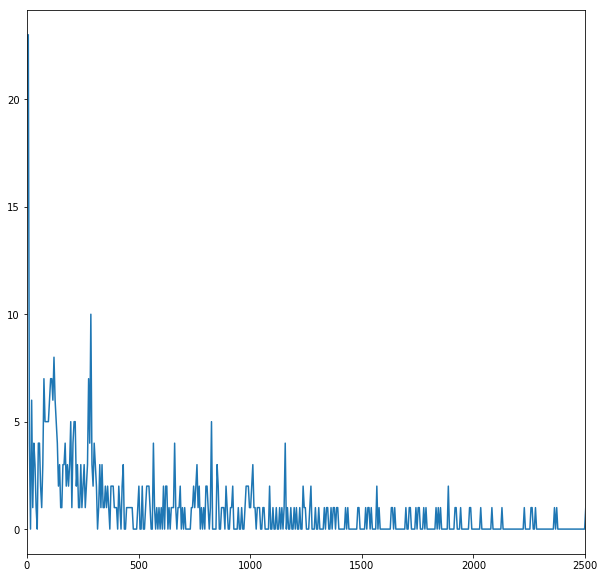

In [70]:
data[data['appid'] == 10].shape
playtimeforapp10 = data.loc[data['appid']==220]['playtime_forever']
numbins = 100000
counts, binedges = np.histogram(playtimeforapp10, bins = numbins )
plt.figure(figsize=(10,10))
plt.plot(binedges[1:], counts)
plt.xlim((0,2500))
counts, binedges

## cdf of playtime distribution for appid 220

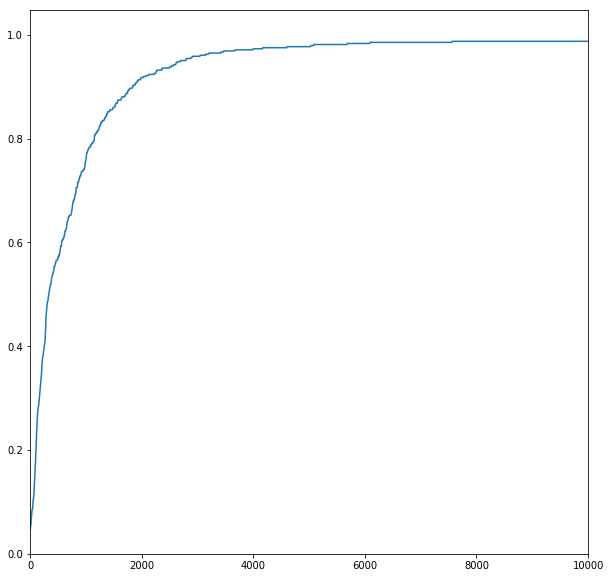

In [71]:
ecdf = np.cumsum(counts)
plt.figure(figsize=(10,10))
plt.plot(binedges[1:], ecdf/ecdf[-1])
plt.xlim((1,10000))
plt.show()

In [72]:
class cdfTransformer(object):
    
    transformerSeries = {}
    
    def getLowerOrEqualIndex(self,playtimeList, playtime):
        if playtime < playtimeList[0]:
            return 0
        ans = 0
        low = 0
        high = len(playtimeList) - 1
        while(low<=high):
            mid = low + (high-low)//2
            if playtime > playtimeList[mid]:
                ans = mid
                low = mid + 1
            elif playtime == playtimeList[mid]:
                return mid
            else:
                high = mid - 1
        return ans      
    
    def getNearestCdf(self,appid, playtime):
        playtimeList = self.transformerSeries[appid].index
        bestpos = self.getLowerOrEqualIndex(playtimeList, playtime)
        return self.transformerSeries[appid].iloc[bestpos]
    
    def fitTransform(self,tupledata):
        grouped1 = tupledata.groupby(["appid","playtime_forever"]).count()
        grouped2 = grouped1.groupby(level=[0]).cumsum()
        grouped3 = grouped2.groupby(level = [0]).max()
        withcdf = grouped2/grouped3
        self.transformerSeries = pd.Series(withcdf['steamid'],index=withcdf.index)
        withcdf_df = withcdf.reset_index(level=[0,1])
        withcdf_df.rename(columns={"steamid":"playtime_cdf"}, inplace=True)
        finaltuple = pd.merge(withcdf_df,data, on=['appid','playtime_forever'],how='inner',suffixes=('_newdf',''))
        return finaltuple

    def Transform(self,tupledata):
        ansdata = tupledata.groupby(["appid","playtime_forever"]).count().reset_index()
        ansdata.drop('steamid', inplace = True, axis = 1)
        ansdata['playtime_cdf'] =  ansdata.apply(lambda x: self.getNearestCdf(x['appid'],x['playtime_forever']), axis = 1)
        return ansdata

In [73]:
transformer1 = cdfTransformer()
newdf = transformer1.fitTransform(data)


In [74]:
transformer1.Transform(data[:600000])

,appid,playtime_forever,Unnamed: 0,playtime_cdf
0,10,1,212,0.391144
1,10,2,11,0.411439
2,10,3,11,0.431734
3,10,4,8,0.446494
4,10,5,1,0.448339
5,10,6,3,0.453875
6,10,7,3,0.459410
7,10,8,4,0.466790
8,10,9,1,0.468635
9,10,11,2,0.472325
